# Task 2

Implement a random Metropolis-Hastings MCMC algorithm, based on the true likelihood (as computed by the exact method proposed by the author), to estimate the parameters of the model for the data mentioned in the paper.

In [1]:
import sys
import os

# 1. On récupère le dossier où se trouve le notebook
current_dir = os.getcwd()

# 2. On remonte d'un cran pour trouver la racine du projet
# (Si votre notebook est dans un sous-sous-dossier, répétez os.path.dirname une fois de plus)
project_root = os.path.dirname(current_dir)

# 3. On ajoute ce chemin à Python s'il n'y est pas déjà
if project_root not in sys.path:
    sys.path.append(project_root)

# 4. Vérification (optionnel)
print(f"Racine ajoutée : {project_root}")
print(f"Dossier 'src' détecté ? : {os.path.isdir(os.path.join(project_root, 'src'))}")

Racine ajoutée : /home/onyxia/work/Non-Gaussian-State-Space-Models
Dossier 'src' détecté ? : True


In [2]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from scipy.special import gammaln
from scipy.stats import poisson, nbinom
from tqdm import tqdm
import openpyxl


# particles library usage 
import particles
import particles.state_space_models as ssm
import particles.distributions as dists


# project related packages
import src.cox_simulation as cx
import utils.plots as pl
import src.creal_filter as cf 
import src.particle_filter as pf
import src.metropolis as mt
import utils.load_data as ld

✅ Chargé: Serie_1 (Beta: None)


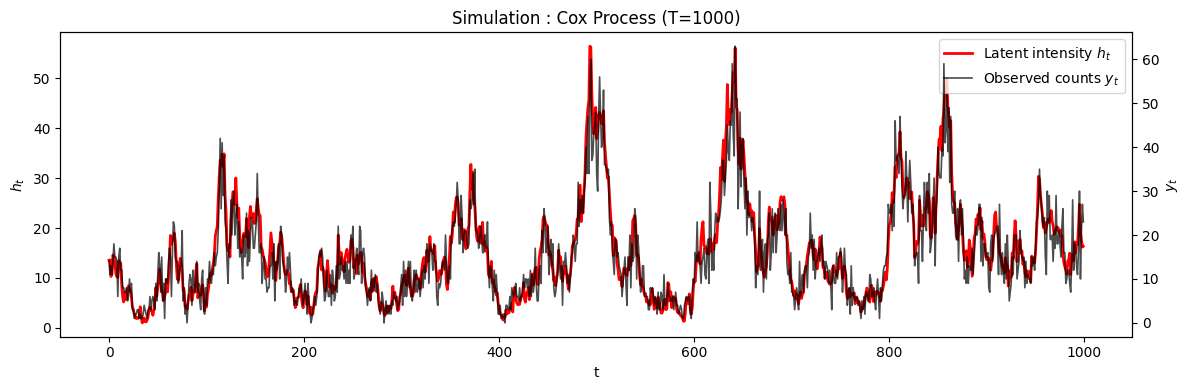

In [3]:
# {"phi": 0.965, "nu": 2.5, "c": 0.2} sans covariates
excel_path = os.path.join(project_root, "data", "data_groupe_T1000.xlsx")
y1, X1, h1, beta1, p1 = ld.load_data(excel_path, "Serie_1")
pl.plot_overlay_clean(y1, h1, T_show=1000, start=0)

✅ Chargé: Serie_2 (Beta: [-0.5  0.3])


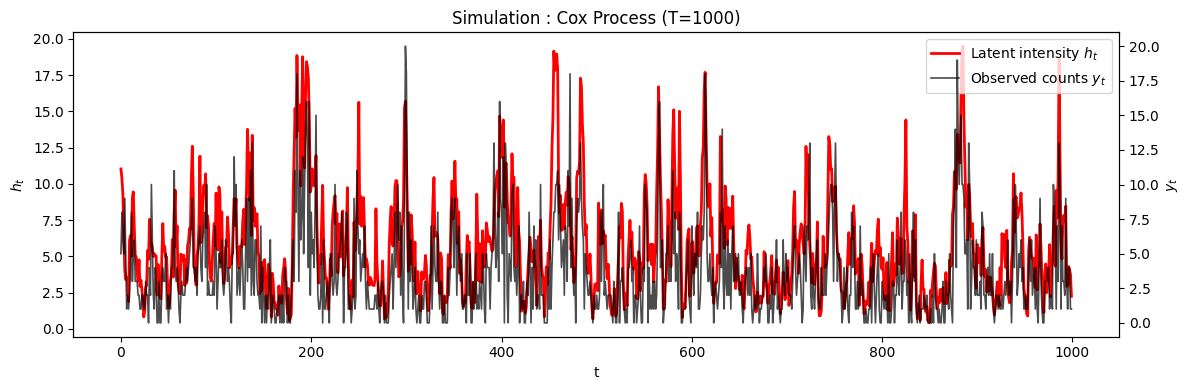

In [4]:
# {"phi": 0.8, "nu": 3, "c": 0.4} avec covariates; beta1 = np.array([-0.5, 0.3])
y2, X2, h2, beta2, p2 = ld.load_data(excel_path, "Serie_2")
pl.plot_overlay_clean(y2, h2, T_show=1000, start=0)


✅ Chargé: Serie_3 (Beta: [-0.5  0.4 -0.3])


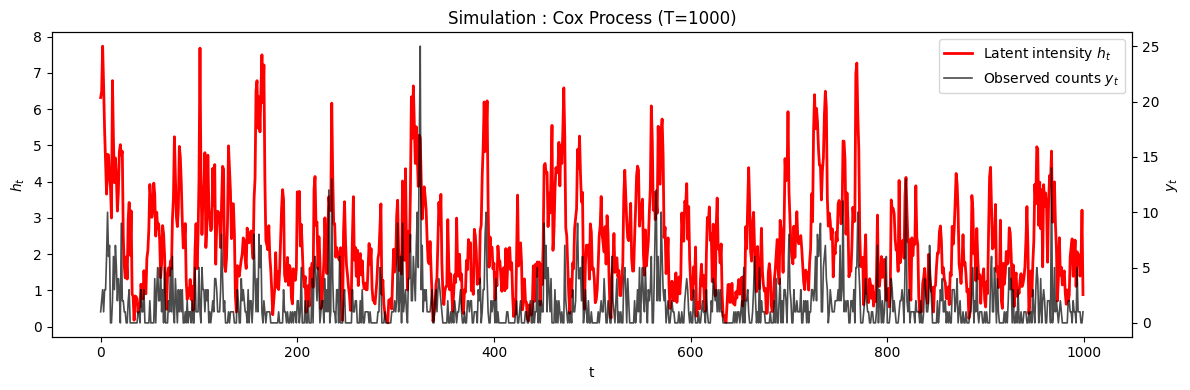

In [5]:
# params_3 = {"phi": 0.8, "nu": 2.5, "c": 0.2} beta2 = np.array([-0.5, 0.4, -0.3])
y3, X3, h3, beta3, p3 = ld.load_data(excel_path, "Serie_3")
pl.plot_overlay_clean(y3, h3, T_show=1000, start=0)


In [6]:
# Exact filter truncation
Z_TRUNC = 200
exact1 = cf.ExactFilter(y1, Z_trunc=Z_TRUNC)

In [7]:
# 2. Lance le MCMC
#0.965, "nu": 2.5, "c": 0.2
# On part des vraies valeurs ou proche pour tester
#chain_results = mt.run_metropolis_exact(
#    y1, 
#    exact1, 
#    n_iterations=2500, 
#    initial_theta=[0.8, 2.5, 0.5], # phi, nu, c
#    proposal_std=[0.008, 0.07, 0.03] # Petits pas pour commencer
#)

🚀 Lancement de 20 chaînes MCMC en parallèle sur CPU...


Progression globale: 100%|██████████| 20/20 [00:00<00:00, 341.73it/s]



      DÉTAIL DES TAUX D'ACCEPTATION
Moyenne globale : 48.88%

Chaîne 01 : 50.43%  -> 👌 Acceptable
Chaîne 02 : 49.10%  -> ✅ Optimal
Chaîne 03 : 50.17%  -> 👌 Acceptable
Chaîne 04 : 50.07%  -> 👌 Acceptable
Chaîne 05 : 47.97%  -> ✅ Optimal
Chaîne 06 : 47.43%  -> ✅ Optimal
Chaîne 07 : 48.93%  -> ✅ Optimal
Chaîne 08 : 48.77%  -> ✅ Optimal
Chaîne 09 : 48.43%  -> ✅ Optimal
Chaîne 10 : 48.40%  -> ✅ Optimal
Chaîne 11 : 49.47%  -> ✅ Optimal
Chaîne 12 : 48.27%  -> ✅ Optimal
Chaîne 13 : 50.40%  -> 👌 Acceptable
Chaîne 14 : 47.80%  -> ✅ Optimal
Chaîne 15 : 47.87%  -> ✅ Optimal
Chaîne 16 : 48.57%  -> ✅ Optimal
Chaîne 17 : 49.20%  -> ✅ Optimal
Chaîne 18 : 49.30%  -> ✅ Optimal
Chaîne 19 : 48.30%  -> ✅ Optimal
Chaîne 20 : 48.70%  -> ✅ Optimal

✅ Génération Figure 1 : Traceplots...


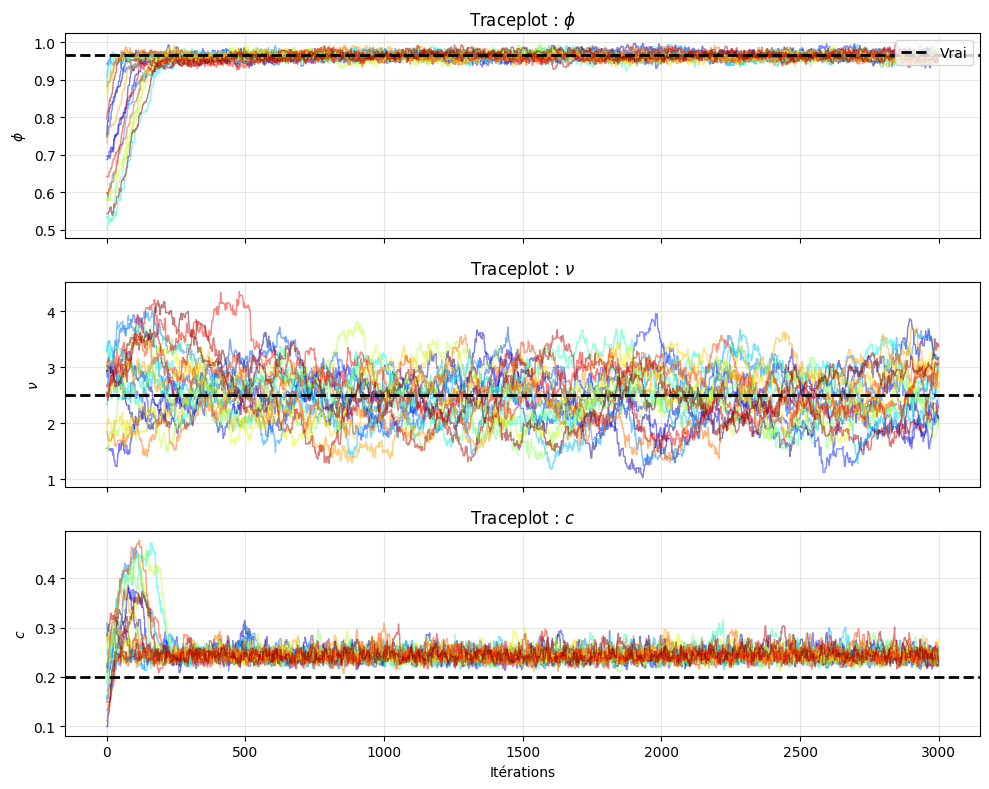


✅ Génération Figure 2 : Histogrammes des Estimateurs...


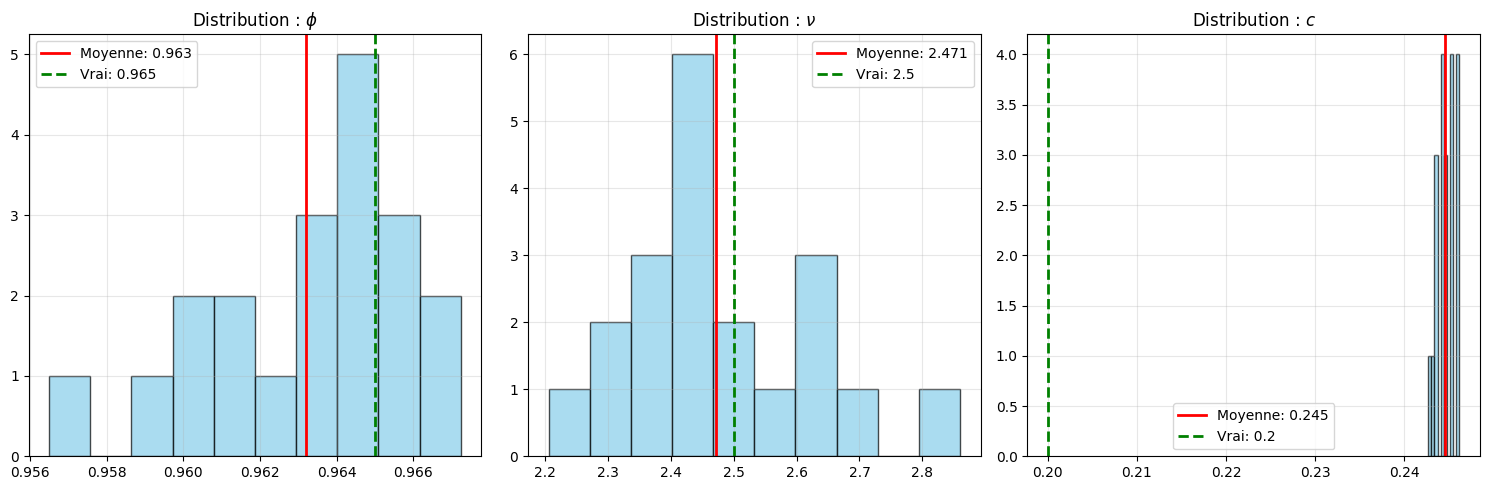


--- RÉSULTATS FINAUX (Agrégés) ---
Phi : 0.9632 +/- 0.0098
Nu  : 2.4711 +/- 0.4696
c   : 0.2446 +/- 0.0125


In [8]:
# --- UTILISATION ---
res = mt.run_multi_chain_mcmc(y1, exact1, n_chains=20, n_iter=3000, true_params=[0.965, 2.5, 0.2], proposal_std=[0.008, 0.07, 0.01],burn_in=1000)

🚀 Lancement de 20 chaînes MCMC en parallèle sur CPU...


Progression globale: 100%|██████████| 20/20 [00:00<00:00, 386.09it/s]



      DÉTAIL DES TAUX D'ACCEPTATION
Moyenne globale : 69.22%

Chaîne 01 : 71.20%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 02 : 68.97%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 03 : 68.77%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 04 : 68.73%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 05 : 70.10%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 06 : 68.97%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 07 : 70.23%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 08 : 71.13%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 09 : 68.03%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 10 : 67.93%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 11 : 70.13%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 12 : 68.17%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 13 : 68.40%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 14 : 70.10%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 15 : 69.23%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 

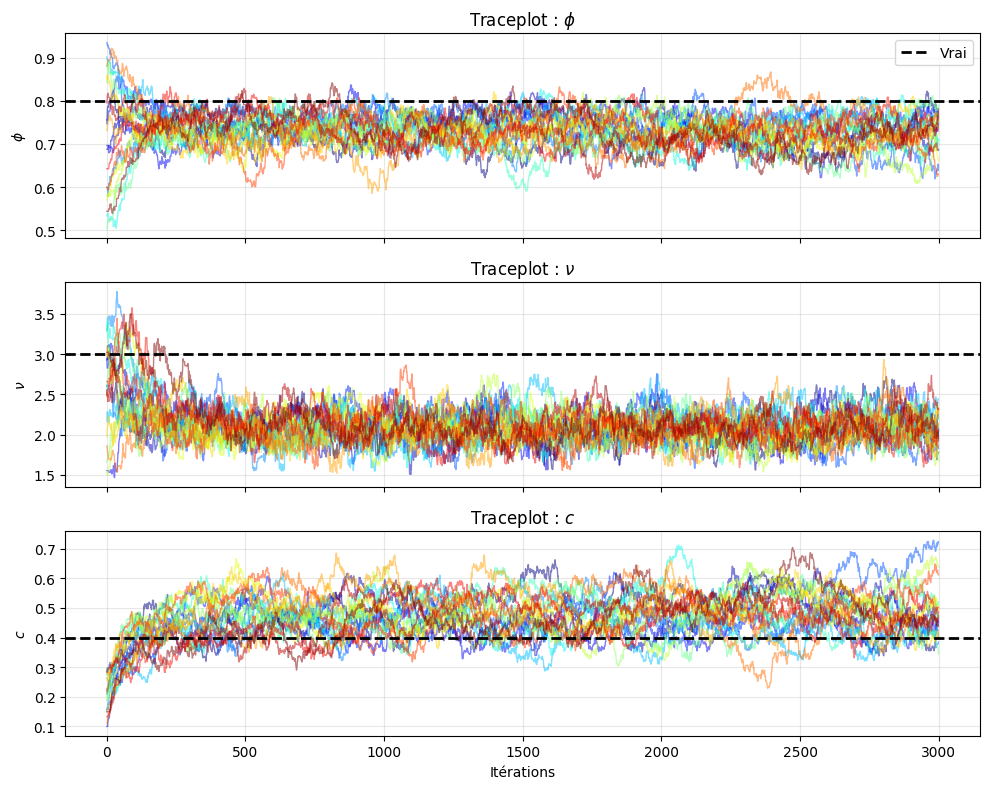


✅ Génération Figure 2 : Histogrammes des Estimateurs...


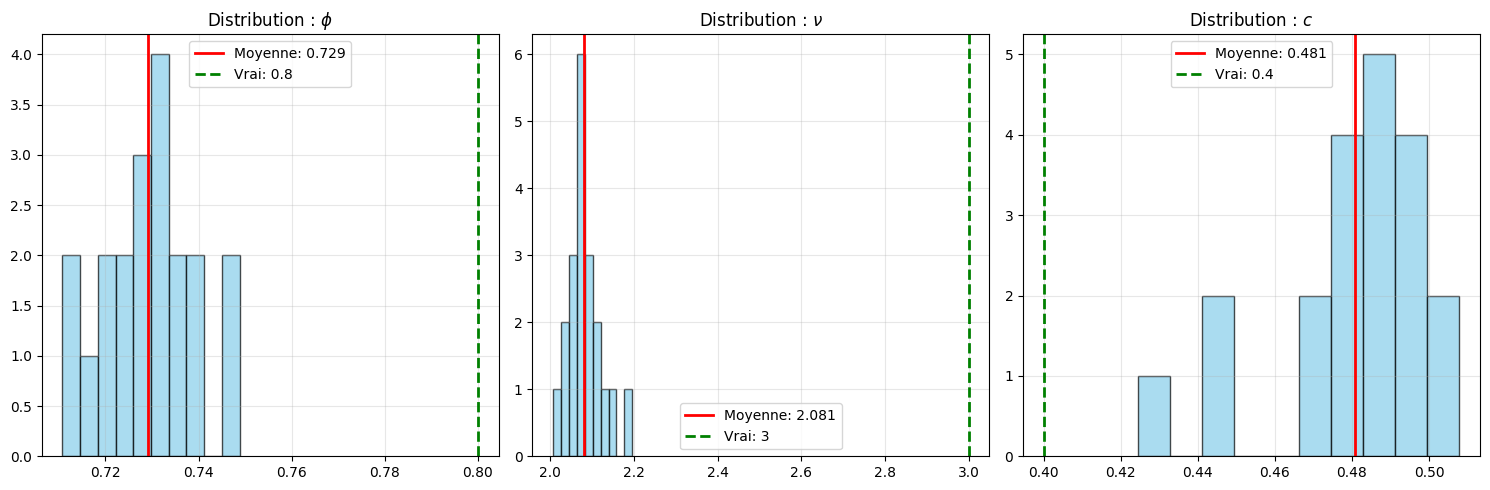


--- RÉSULTATS FINAUX (Agrégés) ---
Phi : 0.7292 +/- 0.0366
Nu  : 2.0813 +/- 0.1875
c   : 0.4809 +/- 0.0681


In [9]:
# {"phi": 0.8, "nu": 3, "c": 0.4} avec covariates; beta1 = np.array([-0.5, 0.3])
exact2 = cf.ExactFilter(y2, Z_trunc=Z_TRUNC)
# --- UTILISATION ---
res = mt.run_multi_chain_mcmc(y2, exact2, n_chains=20, n_iter=3000, true_params=[0.8, 3, 0.4], proposal_std=[0.008, 0.07, 0.01],burn_in=1000)

In [ ]:
# {"phi": 0.8, "nu": 3, "c": 0.4} avec covariates; beta1 = np.array([-0.5, 0.3])
exact2 = cf.ExactFilter(y2, Z_trunc=Z_TRUNC)
# --- UTILISATION ---
res = mt.run_multi_chain_mcmc(y2, exact2, n_chains=10, n_iter=2500, true_params=[0.8, 3, 0.4], proposal_std=[0.015, 0.1, 0.05],burn_in=1000)

🚀 Lancement de 10 chaînes MCMC en parallèle sur CPU...


Progression globale: 100%|██████████| 10/10 [00:00<00:00, 4954.29it/s]


🚀 Lancement de 20 chaînes MCMC en parallèle sur CPU...


Progression globale: 100%|██████████| 20/20 [00:00<00:00, 759.64it/s]



      DÉTAIL DES TAUX D'ACCEPTATION
Moyenne globale : 60.83%

Chaîne 01 : 63.00%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 02 : 59.37%  -> 👌 Acceptable
Chaîne 03 : 60.37%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 04 : 61.10%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 05 : 61.33%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 06 : 60.20%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 07 : 62.93%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 08 : 60.80%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 09 : 58.77%  -> 👌 Acceptable
Chaîne 10 : 61.03%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 11 : 61.43%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 12 : 59.60%  -> 👌 Acceptable
Chaîne 13 : 61.10%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 14 : 61.70%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 15 : 61.03%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 16 : 60.33%  -> ⚠️ Trop élevé (Marche aléatoire lente)
Chaîne 17 : 60.00%  -> 

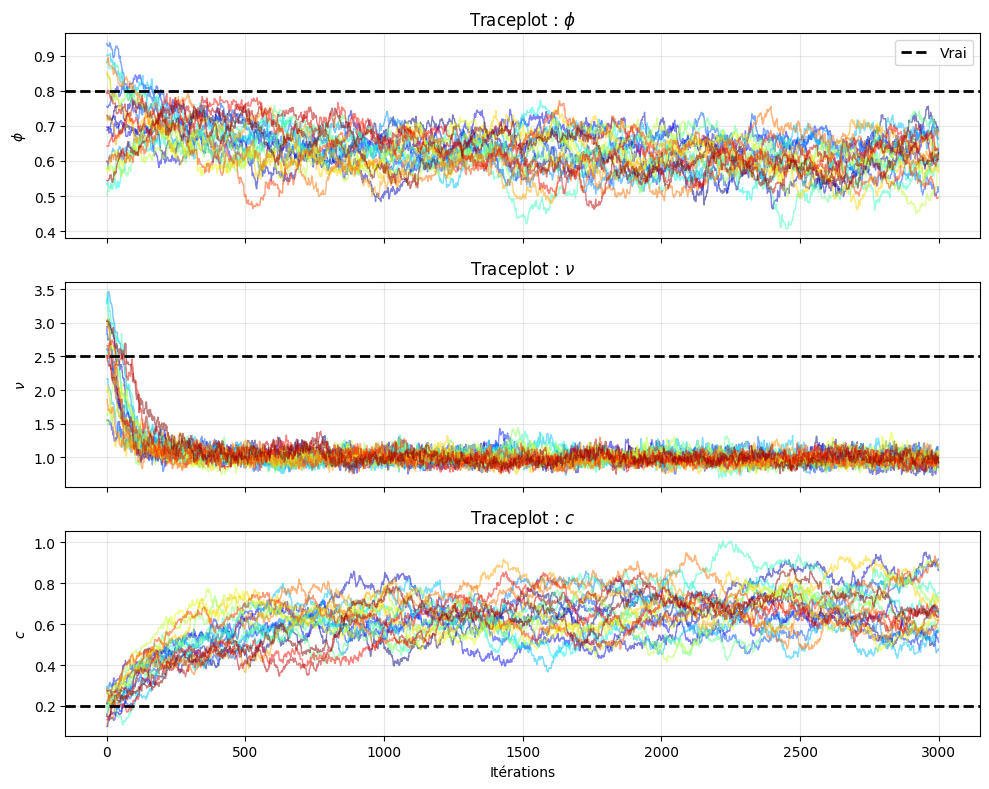


✅ Génération Figure 2 : Histogrammes des Estimateurs...


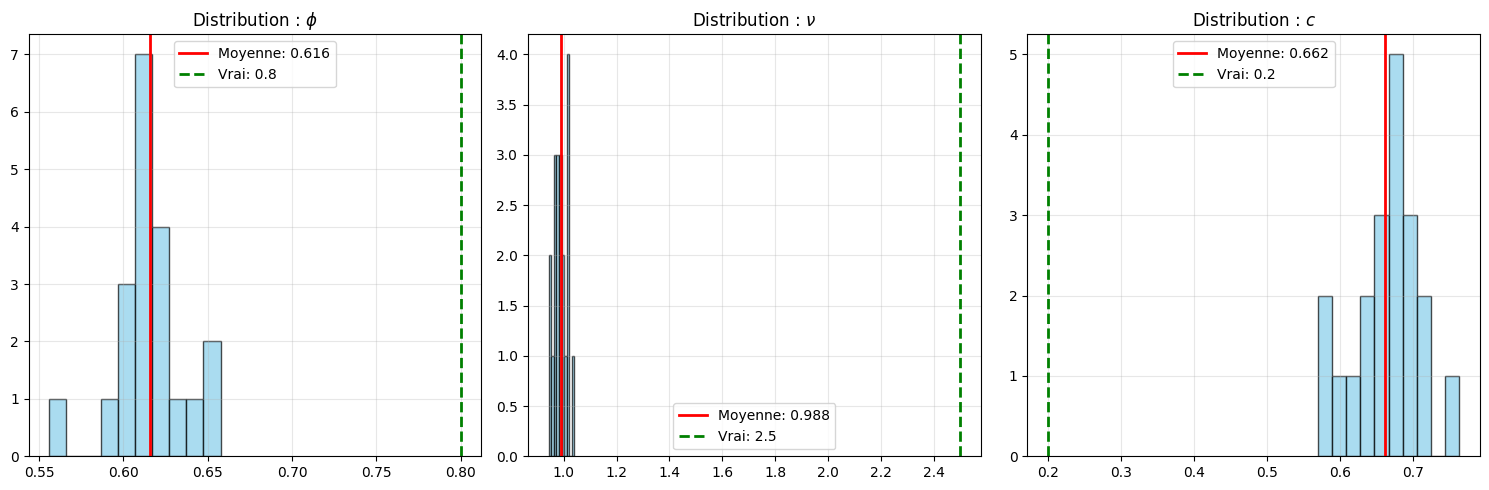


--- RÉSULTATS FINAUX (Agrégés) ---
Phi : 0.6157 +/- 0.0544
Nu  : 0.9877 +/- 0.0939
c   : 0.6622 +/- 0.1045


In [10]:
# params_3 = {"phi": 0.8, "nu": 2.5, "c": 0.2} beta2 = np.array([-0.5, 0.4, -0.3])
exact3 = cf.ExactFilter(y3, Z_trunc=Z_TRUNC)
# --- UTILISATION ---
res = mt.run_multi_chain_mcmc(y3, exact3, n_chains=20, n_iter=3000, true_params=[0.8, 2.5, 0.2], proposal_std=[0.008, 0.07, 0.01],burn_in=1000)

In [ ]:
# params_3 = {"phi": 0.8, "nu": 2.5, "c": 0.2} beta2 = np.array([-0.5, 0.4, -0.3])
exact3 = cf.ExactFilter(y3, Z_trunc=Z_TRUNC)
# --- UTILISATION ---
res = mt.run_multi_chain_mcmc(y3, exact3, n_chains=10, n_iter=2500, true_params=[0.8, 2.5, 0.2], proposal_std=[0.01, 0.1, 0.05],burn_in=1000)